In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

import keras # broken for keras >= 2.0, use 1.2.2
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Flatten, Dense, Activation, Reshape

Using TensorFlow backend.


In [2]:
def load_weights(model,yolo_weight_file):
                
    data = np.fromfile(yolo_weight_file,np.float32)
    data=data[4:]
    
    index = 0
    for layer in model.layers:
        shape = [w.shape for w in layer.get_weights()]
        if shape != []:
            kshape,bshape = shape
            bia = data[index:index+np.prod(bshape)].reshape(bshape)
            index += np.prod(bshape)
            ker = data[index:index+np.prod(kshape)].reshape(kshape)
            index += np.prod(kshape)
            layer.set_weights([ker,bia])


class Box:
    def __init__(self):
        self.x, self.y = float(), float()
        self.w, self.h = float(), float()
        self.c = float()
        self.prob = float()

def overlap(x1,w1,x2,w2):
    l1 = x1 - w1 / 2.;
    l2 = x2 - w2 / 2.;
    left = max(l1, l2)
    r1 = x1 + w1 / 2.;
    r2 = x2 + w2 / 2.;
    right = min(r1, r2)
    return right - left;

def box_intersection(a, b):
    w = overlap(a.x, a.w, b.x, b.w);
    h = overlap(a.y, a.h, b.y, b.h);
    if w < 0 or h < 0: return 0;
    area = w * h;
    return area;

def box_union(a, b):
    i = box_intersection(a, b);
    u = a.w * a.h + b.w * b.h - i;
    return u;

def box_iou(a, b):
    return box_intersection(a, b) / box_union(a, b);


def yolo_net_out_to_car_boxes(net_out, threshold = 0.2, sqrt=1.8,C=20, B=2, S=7):
    class_num = 14
    boxes = []
    SS        =  S * S # number of grid cells
    print (SS)
    prob_size = SS * C # class probabilities
    print (prob_size)
    conf_size = SS * B # confidences for each grid cell
    print (conf_size)
    
    probs = net_out[0 : prob_size]
    print (max(probs))
    confs = net_out[prob_size : (prob_size + conf_size)]
    cords = net_out[(prob_size + conf_size) : ]
    probs = probs.reshape([SS, C])
    print (probs.shape)
    confs = confs.reshape([SS, B])
    cords = cords.reshape([SS, B, 4])
    
    for grid in range(SS):
        for b in range(B):
            bx   = Box()
            bx.c =  confs[grid, b]
            bx.x = (cords[grid, b, 0] + grid %  S) / S
            bx.y = (cords[grid, b, 1] + grid // S) / S
            bx.w =  cords[grid, b, 2] ** sqrt 
            bx.h =  cords[grid, b, 3] ** sqrt
            p = probs[grid, :] * bx.c
            
            if p[class_num] >= threshold:
                bx.prob = p[class_num]
                boxes.append(bx)
                
    # combine boxes that are overlap
    boxes.sort(key=lambda b:b.prob,reverse=True)
    for i in range(len(boxes)):
        boxi = boxes[i]
        if boxi.prob == 0: continue
        for j in range(i + 1, len(boxes)):
            boxj = boxes[j]
            if box_iou(boxi, boxj) >= .4:
                boxes[j].prob = 0.
    boxes = [b for b in boxes if b.prob > 0.]
    
    return boxes

def draw_box(boxes,im,crop_dim):
    imgcv = im
    [xmin,xmax] = crop_dim[0]
    [ymin,ymax] = crop_dim[1]
    for b in boxes:
        h, w, _ = imgcv.shape
        left  = int ((b.x - b.w/2.) * w)
        right = int ((b.x + b.w/2.) * w)
        top   = int ((b.y - b.h/2.) * h)
        bot   = int ((b.y + b.h/2.) * h)
        left = int(left*(xmax-xmin)/w + xmin)
        right = int(right*(xmax-xmin)/w + xmin)
        top = int(top*(ymax-ymin)/h + ymin)
        bot = int(bot*(ymax-ymin)/h + ymin)

        if left  < 0    :  left = 0
        if right > w - 1: right = w - 1
        if top   < 0    :   top = 0
        if bot   > h - 1:   bot = h - 1
        thick = int((h + w) // 150)
        cv2.rectangle(imgcv, (left, top), (right, bot), (255,0,0), thick)

    return imgcv

In [3]:
keras.backend.set_image_dim_ordering('th')

In [4]:
model = Sequential()
model.add(Convolution2D(16, 3, 3,input_shape=(3,448,448),border_mode='same',subsample=(1,1)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(64,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(128,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(256,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(512,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(1024,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(Convolution2D(1024,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(Convolution2D(1024,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(Flatten())
model.add(Dense(256))
model.add(Dense(4096))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(1470))

In [5]:
#model.summary()

In [6]:
load_weights(model,'./yolo-tiny.weights')

In [7]:
imagePath = '../samples/test_images/car1.jpg'
image = plt.imread(imagePath)
image_crop = image[300:650,500:,:]
resized = cv2.resize(image_crop,(448,448))

In [8]:
batch = np.transpose(resized,(2,0,1))
batch = 2*(batch/255.) - 1
batch = np.expand_dims(batch, axis=0)
out = model.predict(batch)

49
980
98
0.630264
(49, 20)


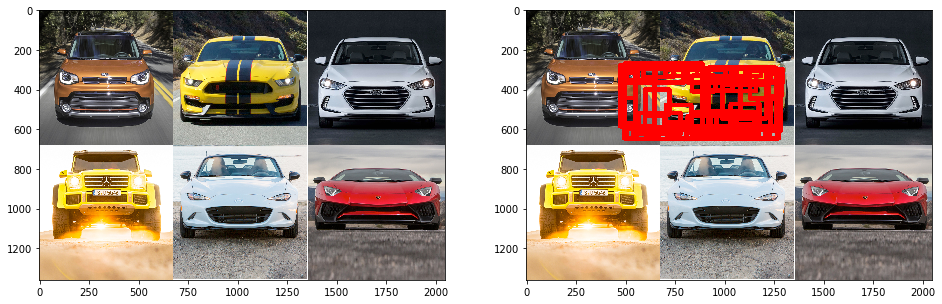

In [10]:
boxes = yolo_net_out_to_car_boxes(out[0], threshold = 0)
f,(ax1,ax2) = plt.subplots(1,2,figsize=(16,6))
ax1.imshow(image)
ax2.imshow(draw_box(boxes,plt.imread(imagePath),[[500,1280],[300,650]]))